In [26]:
library(tidyverse)
library(ggplot2)
library(RColorBrewer)
library(Seurat)
library(VennDiagram)
library(plyr)

In [2]:
meta_file = '../data/human/mirna/metadata.tsv'
lib_meta_file = '../data/human/mirna/mirna_human_library_data_summary.tsv'

# microRNA figure

In [27]:
meta = read.delim(meta_file)
meta$Biosample_type = meta$Biosample.type
meta$Biosample_type = gsub("cell line","Cell line",meta$Biosample_type)
meta$Biosample_type = gsub("in vitro differentiated cells","Cell line",meta$Biosample_type)
meta$Biosample_type = gsub("primary cell","Cell line",meta$Biosample_type)
meta$Biosample_type = gsub("tissue","Tissue",meta$Biosample_type)
meta$Biosample_type_brain = meta$Biosample_type

for (i in 1:nrow(meta)){
    if (meta$Biosample.term.name[i] == "dorsolateral prefrontal cortex"){
        meta$Biosample_type_brain[i] = "Brain"
    } else {
        meta$Biosample_type_brain[i] = meta$Biosample_type_brain[i]
    }
}

In [28]:
path = '../data/human/mirna/'
samples = dir(path)
samples = samples[grepl('ENCFF', samples)]

thisMat=read.table(paste0(path,samples[1]),sep="",head=FALSE)
counts=thisMat[-c(1:4),c(1,2)]

for(i in 2:length(samples)){
    thisMat=read.table(paste0(path,samples[i]),sep="",head=FALSE)
    thisMat=thisMat[na.omit(match(counts$V1,thisMat$V1)),]
    counts=cbind(counts,thisMat[,"V2"])
}

colnames(counts) = c("miRNA_ID",do.call("rbind", strsplit(samples, ".tsv"))[,1])
rownames(counts) = counts$miRNA_ID
counts$miRNA_ID = NULL

# Sort metadata
meta = meta[match(colnames(counts), meta$File.accession),]
dim(meta)

[1] 254  61

In [29]:
# Convert to CPM (counts per million)
cpm_func <- function(counts) {
  cpm <- apply(counts,2, function(x) (x/sum(x))*1000000)
  cpm = as.matrix(cpm)
  rownames(cpm) = rownames(counts)
  colnames(cpm) = colnames(counts)
  return(cpm)
}             
               
cpm = cpm_func(counts[rowSums(counts)>0,])
cpm2 = as.data.frame(colSums(cpm >= 2))
colnames(cpm2) = "Expressed_miRNAs"
cpm2$File.accession = rownames(cpm2)
cpm2 = left_join(cpm2, meta)
cpm2$Biosample_type_brain = factor(cpm2$Biosample_type_brain,
                                  levels = c("Cell line","Tissue","Brain"))

Joining, by = "File.accession"



## miRNA detection by biotype

Warning message:
“Removed 1 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


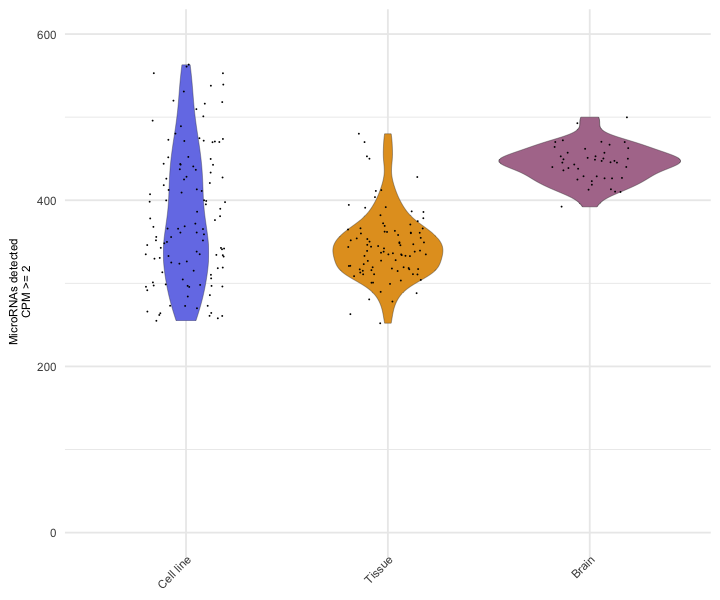

In [30]:
ggplot(cpm2, aes(x=Biosample_type_brain, y=Expressed_miRNAs, fill=Biosample_type_brain)) + 
  geom_violin(size=0.1) + 
    geom_jitter(size=0.2,shape=16, position=position_jitter(0.2))+ 
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1, size =7)) + 
    theme(axis.title.x = element_blank())+ ylab("MicroRNAs detected     \nCPM >= 2     ")+
    xlab("Biosample type")+ylim(0,600)+
    theme(axis.title.y = element_text(size = 7),
         axis.text.y = element_text(size =7),
         legend.text=element_text(size=7),
         legend.title=element_blank(),
         axis.ticks.x=element_blank())+
    scale_fill_manual(values = c("#7680E8","#E39F24","#B0799A"))+
     theme(axis.text.x = element_text(margin = margin(t = -5, r = 0, b = 0, l = 0))) +
    theme(legend.position = "none")

## miRNA detection by sample type

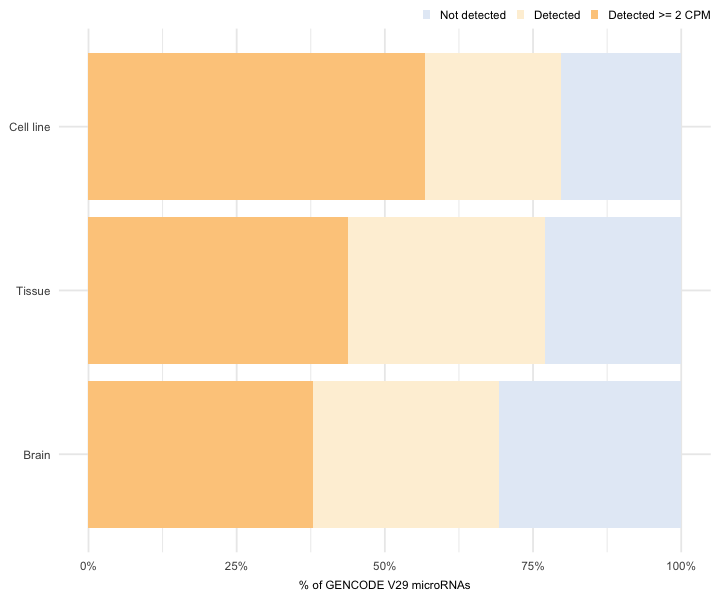

In [31]:
cpm_tissue = as.data.frame(cpm_func(counts[,colnames(counts) %in% meta$File.accession[meta$Biosample_type_brain == "Tissue"]]))
expressed=c()
for (i in 1:nrow(cpm_tissue)){
    if (max(cpm_tissue[i,]) >= 2){
        expressed[i] = "Detected >= 2 CPM"
    } else if (max(cpm_tissue[i,]) > 0) {
        expressed[i] = "Detected"
    } else {
        expressed[i] = "Not detected"
    }
    
}
df = data.frame(expressed = expressed)
df$Biosample_type_brain = "Tissue"
df$expressed = factor(df$expressed, levels = c("Not detected","Detected","Detected >= 2 CPM"))


cpm_cells = as.data.frame(cpm_func(counts[,colnames(counts) %in% meta$File.accession[meta$Biosample_type_brain == "Cell line"]]))
expressed=c()
for (i in 1:nrow(cpm_cells)){
    if (max(cpm_cells[i,]) >= 2){
        expressed[i] = "Detected >= 2 CPM"
    } else if (max(cpm_cells[i,]) > 0) {
        expressed[i] = "Detected"
    } else {
        expressed[i] = "Not detected"
    }
    
}
df2 = data.frame(expressed = expressed)
df2$Biosample_type_brain = "Cell line"
df2$expressed = factor(df2$expressed, levels = c("Not detected","Detected","Detected >= 2 CPM"))


cpm_brain = as.data.frame(cpm_func(counts[,colnames(counts) %in% meta$File.accession[meta$Biosample_type_brain == "Brain"]]))
expressed=c()
for (i in 1:nrow(cpm_brain)){
    if (max(cpm_brain[i,]) >= 2){
        expressed[i] = "Detected >= 2 CPM"
    } else if (max(cpm_brain[i,]) > 0) {
        expressed[i] = "Detected"
    } else {
        expressed[i] = "Not detected"
    }
    
}
df3 = data.frame(expressed = expressed)
df3$Biosample_type_brain = "Brain"
df3$expressed = factor(df3$expressed, levels = c("Not detected","Detected","Detected >= 2 CPM"))


df = rbind(df,df2,df3)

df$Biosample_type_brain = factor(df$Biosample_type_brain, levels = c("Brain","Tissue","Cell line"))

ggplot(df, aes(x=Biosample_type_brain, fill=expressed)) + 
    geom_bar(position = "fill") + theme_minimal() +
    scale_fill_manual(values = c("#e4ecf6","#fef0d9","#fdcc8a")) + 
    coord_flip() + ylab("% of GENCODE V29 microRNAs") + 
    theme(axis.title.y = element_blank(),
          axis.text.y = element_text(size = 7),
          axis.title.x = element_text(size = 7),
          legend.text=element_text(size=7),
          legend.title=element_blank(),
          axis.text.x=element_text(size = 7))+#,
          #legend.background = element_rect(color = NA,fill=alpha('white', 1)))+  
    theme(legend.key.size = unit(2, 'mm')) +
    theme(axis.title.x = element_text(margin = margin(t = 5, r = 0, b = 0, l = 0))) +
    scale_y_continuous(labels = scales::percent_format())+
    theme(legend.position="top",
       legend.justification="right", 
       legend.box.spacing = unit(0, "pt"),# The spacing between the plotting area and the legend box (unit)
       legend.margin=margin(0,0,5,0))


## miRNA detection by sample


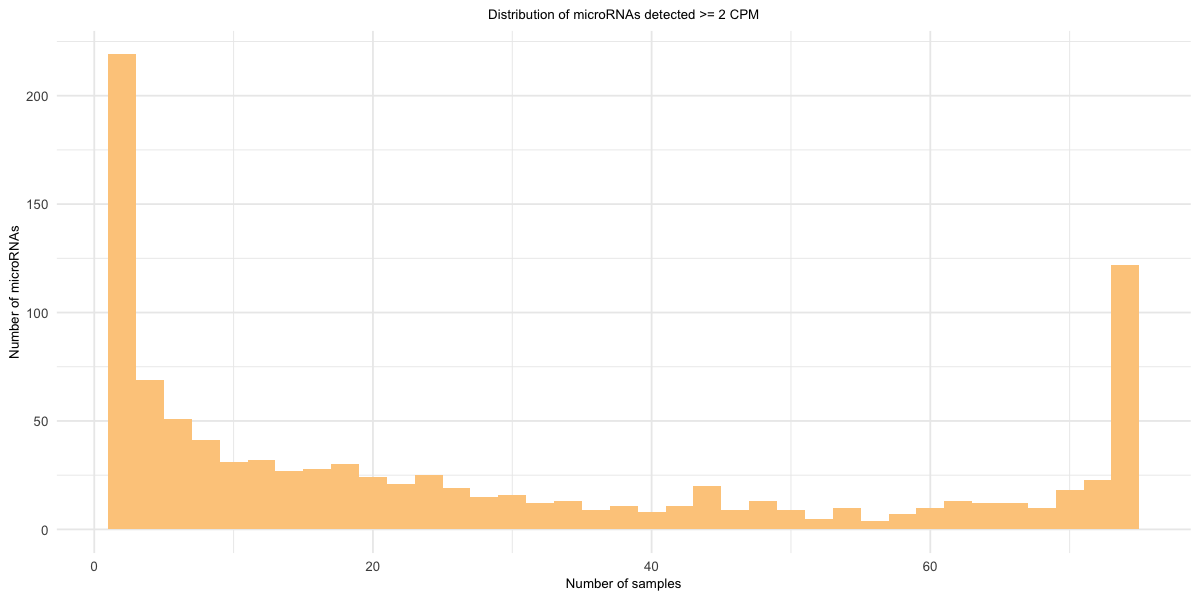

In [32]:
file_to_sample = read.delim(lib_meta_file)
meta = left_join(meta, file_to_sample, by = c('File.accession'='ENCODE_file_id'))
meta = meta[match(colnames(counts),meta$File.accession),]
               
# collapse counts per sample
counts_collapsed = as.data.frame(t(as.matrix(counts)))
counts_collapsed$sample = meta$sample
counts_collapsed = ddply(counts_collapsed,"sample",numcolwise(sum)) # sum up libraries per sample
rn = counts_collapsed$sample
counts_collapsed$sample = NULL
counts_collapsed = as.matrix(counts_collapsed)
rownames(counts_collapsed) = rn
counts_collapsed = t(counts_collapsed)

cpm_collapsed = as.data.frame(cpm_func(counts_collapsed[rowSums(counts_collapsed) > 0,]))

cpm_greaterthan2_func <- function(cpm_0) {
  check_max_cpm = max(cpm_0[1,])
  for (i in 2:dim(cpm_0)[1]) {
    check_max_cpm = c(check_max_cpm, max(cpm_0[i,]))
  }
  cpm_2 = cpm_0[which(check_max_cpm>2),]
  return(cpm_2)
}


cpm2_collapsed = cpm_greaterthan2_func(cpm_collapsed)

df = data.frame(nSample = rowSums(1*(cpm2_collapsed>2)))
df$sample = "all_samples"

options(repr.plot.width = 10, repr.plot.height = 5)

ggplot(df) + geom_histogram(
    position = "dodge", aes(x = nSample, fill = sample), 
    binwidth=2) + 
    theme_minimal() + 
    scale_fill_manual(values = c("#fdcc8a")) +
    ylab("Number of microRNAs") +
    xlab("Number of samples") + 
    ggtitle("Distribution of microRNAs detected >= 2 CPM")+
    theme(legend.key.size = unit(1, 'lines'),
          axis.title.x = element_text(size = 8),
          axis.text.x = element_text(size = 8),
          axis.title.y = element_text(size = 8),
          axis.text.y = element_text(size = 8),
          legend.text=element_text(size=8),
          legend.title=element_blank(),
          legend.background = element_rect(color = 'white',fill=alpha('white', 0.5)),  
          plot.title = element_text(hjust = 0.5, size = 8))+ 
           theme(legend.position = c(0.8, 0.7))+ theme(legend.position = "none")

## Sample specificity Venn diagram

In [19]:
cpm = cpm_func(counts[rowSums(counts)>0,])
cpm_long = as.data.frame(cbind(miRNA = rownames(cpm), cpm))
cpm_long =  gather(cpm_long, File.accession, cpm, ENCFF006ELI:ENCFF995TKW)
cpm_long$cpm = as.numeric(cpm_long$cpm)
cpm_long$cpm0 = 1*(cpm_long$cpm > 0)
cpm_long$cpm2 = 1*(cpm_long$cpm >= 2)

cpm_long = left_join(cpm_long, meta[,c("File.accession","Biosample_type_brain")], by = "File.accession")

venn_cpm2 = cpm_long[cpm_long$cpm2 > 0,]
venn_cpm2$File.accession = NULL
venn_cpm2$cpm = NULL
venn_cpm2$cpm0 = NULL
venn_cpm2 = unique(venn_cpm2)
venn_cpm2 = spread(venn_cpm2, key = Biosample_type_brain, value = cpm2)
venn_cpm2[is.na(venn_cpm2)] <- 0

venn_cpm2_tissue_mirnas = venn_cpm2$miRNA[venn_cpm2$Tissue == 1]

venn_cpm2_brain_mirnas = venn_cpm2$miRNA[venn_cpm2$Brain == 1]

venn_cpm2_cell_mirnas = venn_cpm2$miRNA[venn_cpm2$`Cell line` == 1]

venn_cpm2 = list(Tissue_only = venn_cpm2_tissue_mirnas,
                Cells_only = venn_cpm2_cell_mirnas,
                Brain_only = venn_cpm2_brain_mirnas)

futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")
venn.diagram(
    x = venn_cpm2,
    category.names = c("Tissue","Cell line" ,"Brain"),
    scaled = FALSE ,
    height = 40 , 
    width = 40 ,
    units = "mm", 
    lwd = 2,
    lty = 'blank',
    fill = c("#E39F24","#7680E8","pink"),
    filename = 'figures/cpm2_venn_diagram_brain.png',
    output=TRUE,
    # Numbers
    cex = .6,
    fontface = "bold",
    fontfamily = "sans",
    # Set names
    cat.cex = 0.6,imagetype = "png",
    cat.fontface = "bold",
    #cat.default.pos = "outer",
    cat.pos = c(-30, 30, 0),
    cat.dist = c(-0.05, -0.05,-0.36),
    cat.fontfamily = "sans"
)

Warning message:
“attributes are not identical across measure variables;
they will be dropped”


NULL

[1] 1

## PCA plot of libraries

In [25]:
cpm_greaterthan2_func <- function(cpm_0) {
  check_max_cpm = max(cpm_0[1,])
  for (i in 2:dim(cpm_0)[1]) {
    check_max_cpm = c(check_max_cpm, max(cpm_0[i,]))
  }
  cpm_2 = cpm_0[which(check_max_cpm>=2),]
  return(cpm_2)
}

cpm2 = cpm_greaterthan2_func(cpm)

cpm2_pca <- prcomp(t(log2(cpm2+1)))
cpm2_pca_out <- as.data.frame(cpm2_pca$x)
cpm2_pca_out$File.accession = rownames(cpm2_pca_out)
cpm2_pca_out$var_explained = (cpm2_pca$sdev/sum(cpm2_pca$sdev))*100
cpm_2_pca_plus_metadata = join(cpm2_pca_out, meta)
cpm_2_pca_plus_metadata$Biosample_type_brain = factor(cpm_2_pca_plus_metadata$Biosample_type_brain,
                                                     levels=c("Cell line","Tissue","Brain"))

p=ggplot(cpm_2_pca_plus_metadata,
       aes(x=PC1,y=PC2,color=Biosample_type_brain)) + geom_point(size = 0.5) + 
theme_bw() + xlab(paste0("PC1 (", round(cpm_2_pca_plus_metadata$var_explained[1],2), "%)"))+ 
ylab(paste0("PC2 (", round(cpm_2_pca_plus_metadata$var_explained[2],2), "%)"))+ 
theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())+
scale_color_manual(values = c("#7680E8","#E39F24","#B0799A"))+ theme(legend.margin=unit(-0.6,"cm"))

options(repr.plot.width = 6, repr.plot.height = 5)

p +
  theme(
        legend.key.size = unit(0.5, 'lines')) +
    theme(legend.text=element_text(size=8),
          axis.title.x = element_text(size = 8),
          axis.title.y = element_text(size = 8),
          legend.title = element_blank(),
          axis.ticks.x = element_blank(),
          axis.ticks.y = element_blank(),
          axis.text.y = element_blank(),
          axis.text.x = element_blank(),
          plot.title = element_blank())+
    theme(plot.margin = unit(c(0,2,1,1), "mm"))+ 
    guides(color = guide_legend(override.aes = list(size=1.5)))+
    theme(legend.position = c(0.21, 0.8)),
       dpi = 1000,
       width = 50,
       height = 40,
       units ="mm") 

Joining by: File.accession

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
